Instalação e importação dos pacotes necessários:

In [1]:
!python.exe -m pip install --upgrade pip
!pip3 install pyspark
!pip3 install spark
!pip3 install findspark
!pip3 install matplotlib
!pip3 install numpy

In [2]:
import findspark
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
findspark.init()


In [4]:
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import *
from pyspark.sql import *

Criação das variáveis de ambiente e configurações para acessar o Cassandra:

In [6]:
os.environ['HADOOP_HOME'] ='C:/Users/julia/Downloads/winutils-master (1)/winutils-master/hadoop-3.2.1'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.datastax.spark:spark-cassandra-connector_2.12:3.4.1 pyspark-shell'
conf = SparkConf()
conf.set("spark.cassandra.connection.host", "127.0.0.1")
conf.set("spark.cassandra.connection.port", "9042")
print(conf)

Criação do SparkContext para conectar ao Spark:

In [7]:
sc = SparkContext().getOrCreate(conf=conf)

Para fazer queries com SQL:

In [8]:
sqlContext = SQLContext(sc)

C:\Users\julia\AppData\Roaming\JetBrains\DataSpell2023.3\projects\workspace\venv\lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Leitura e carregamento dos dados da tabela anteriormente criada em Cassandra "avaliacoes_por_filme" no keyspace "filmes":

In [9]:
avaliacoes_por_filme = sqlContext.read.format("org.apache.spark.sql.cassandra").load(table="avaliacoes_por_filme", keyspace="filmes")

Dados da tabela:

In [10]:
avaliacoes_por_filme.show()

+--------+-------+----------+------+
|movie_id|user_id|      name|rating|
+--------+-------+----------+------+
|    2153|      7|Free Willy|     4|
|    2153|     79|Free Willy|     5|
|    2153|    134|Free Willy|     5|
|    2153|    268|Free Willy|     5|
|    2153|    383|Free Willy|     3|
|    2153|    609|Free Willy|     3|
|    2153|    756|Free Willy|     1|
|    2153|   1044|Free Willy|     3|
|    2153|   1333|Free Willy|     2|
|    2153|   1409|Free Willy|     4|
|    2153|   1611|Free Willy|     5|
|    2153|   1664|Free Willy|     5|
|    2153|   1702|Free Willy|     4|
|    2153|   1715|Free Willy|     4|
|    2153|   1830|Free Willy|     4|
|    2153|   1894|Free Willy|     4|
|    2153|   2050|Free Willy|     3|
|    2153|   2213|Free Willy|     5|
|    2153|   2363|Free Willy|     4|
|    2153|   2455|Free Willy|     3|
+--------+-------+----------+------+


Contagem de dados na tabela:

In [38]:
avaliacoes_por_filme.count()

17337458

Query01 - Qual a média de avaliação (rating) por filme?

In [11]:
consulta_avaliacoes = avaliacoes_por_filme.groupBy("movie_id", "name") \
    .agg(avg(col("rating")).alias("media_avaliacao")) \
    .orderBy(col("media_avaliacao").desc())

Retorno da query01:

In [60]:
consulta_avaliacoes.show()

+--------+--------------------+------------------+
|movie_id|                name|   media_avaliacao|
+--------+--------------------+------------------+
|    3456|      Lost: Season 1| 4.665432098765432|
|    2102|The Simpsons: Sea...| 4.589824034920202|
|    3444|Family Guy: Freak...| 4.520766378244747|
|    1476|Six Feet Under: S...| 4.461601211979955|
|    4238|           Inu-Yasha| 4.457773512476008|
|    2568|Stargate SG-1: Se...| 4.456026058631922|
|    1256|The Best of Frien...| 4.449167996352861|
|    4427|The West Wing: Se...|  4.43625843780135|
|    2452|Lord of the Rings...|  4.43148917942777|
|    1947|Gilmore Girls: Se...| 4.428942582488959|
|    2114|             Firefly| 4.410771903698188|
|    2172|The Simpsons: Sea...| 4.408041422306757|
|    3962|Finding Nemo (Wid...| 4.395903857377832|
|    2019|    Samurai Champloo| 4.395629238884703|
|    3046|The Simpsons: Tre...| 4.395329752312742|
|    3290|       The Godfather| 4.392642600755082|
|    2162|       CSI: Season 1|

Salvar o resultado da Query01 em um arquivo .csv:

In [81]:
consulta_avaliacoes.write.csv("./media_rating.csv", header=True, mode="overwrite")

Criação de gráfico Query01 usando plotmatlib:

In [74]:
#limite dos 20 filmes com maior avaliação
consulta_avaliacoes_20 = consulta_avaliacoes.limit(20)

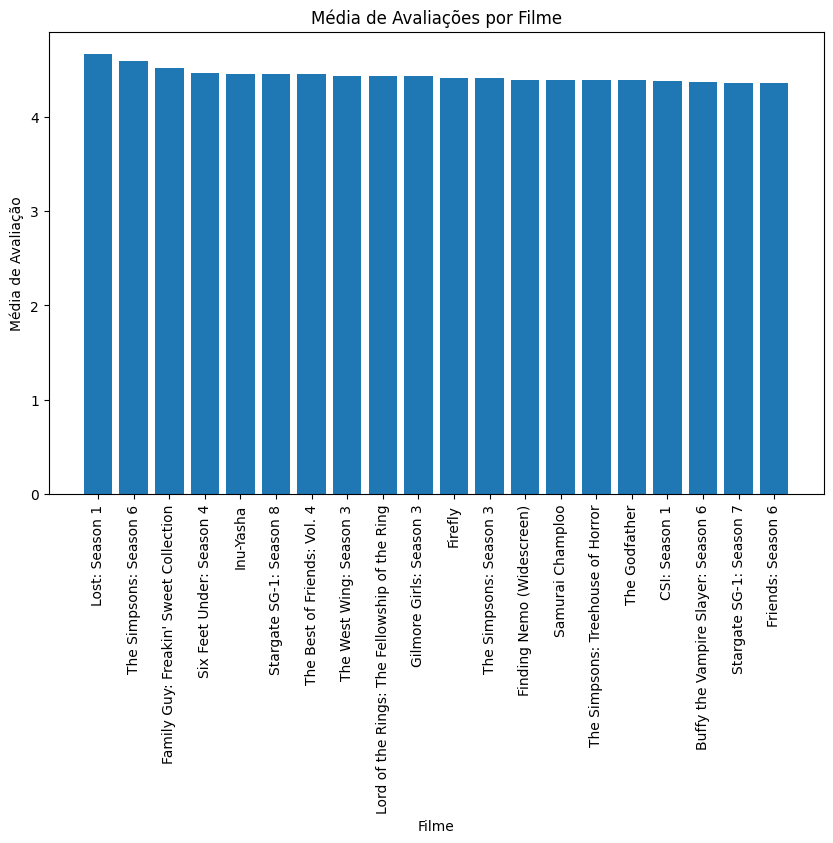

In [71]:
filmes = consulta_avaliacoes_20.select("name").rdd.flatMap(lambda x: x).collect()
medias_avaliacoes = consulta_avaliacoes_20.select("media_avaliacao").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.bar(filmes, medias_avaliacoes)
plt.xlabel('Filme')
plt.ylabel('Média de Avaliação')
plt.title('Média de Avaliações por Filme')
plt.xticks(rotation=90)
plt.show()

Query02 - Quais os filmes que possuem a média de avaliação (rating) maior que 4,5?

In [30]:
consulta_avaliacoes_filtrada = avaliacoes_por_filme.groupBy("movie_id", "name") \
    .agg(avg(col("rating")).alias("media_avaliacao")) \
    .filter(col("media_avaliacao") >= 4.5) \
    .orderBy(col("media_avaliacao").desc())

Retorno da query02:

In [31]:
consulta_avaliacoes_filtrada.show()

+--------+--------------------+-----------------+
|movie_id|                name|  media_avaliacao|
+--------+--------------------+-----------------+
|    3456|      Lost: Season 1|4.665432098765432|
|    2102|The Simpsons: Sea...|4.589824034920202|
|    3444|Family Guy: Freak...|4.520766378244747|
+--------+--------------------+-----------------+


Query03 - Qual a quantidade de avaliações que cada filme possui?

In [12]:
consulta_avaliacoes_contagem = avaliacoes_por_filme.groupBy("name") \
    .agg(count(col("rating")).alias("num_avaliacoes")) \
    .filter(col("num_avaliacoes") > 0) \
    .orderBy(col("num_avaliacoes").desc())


Retorno da query03:

In [13]:
consulta_avaliacoes_contagem.show()

+--------------------+--------------+
|                name|num_avaliacoes|
+--------------------+--------------+
|Pirates of the Ca...|        117075|
|Lord of the Rings...|        102721|
|     The Sixth Sense|        102376|
|     American Beauty|        101450|
|      Bruce Almighty|         98545|
|The Silence of th...|         95053|
|Finding Nemo (Wid...|         94235|
|     The Italian Job|         93886|
|             Shrek 2|         92893|
|          Braveheart|         91502|
|               Ghost|         87082|
|     What Women Want|         86756|
|    The Last Samurai|         86354|
|      50 First Dates|         85605|
|The Bourne Supremacy|         85247|
|    A Beautiful Mind|         82347|
|     Men in Black II|         81371|
|The Matrix: Reloaded|         79504|
|               Speed|         79476|
|Sleepless in Seattle|         78996|
+--------------------+--------------+


Criação do gráfico Query03:

In [14]:
#limite dos 10 filmes com maior quantidade de avaliações
consulta_avaliacoes_contagem_10 = consulta_avaliacoes_contagem.limit(10)

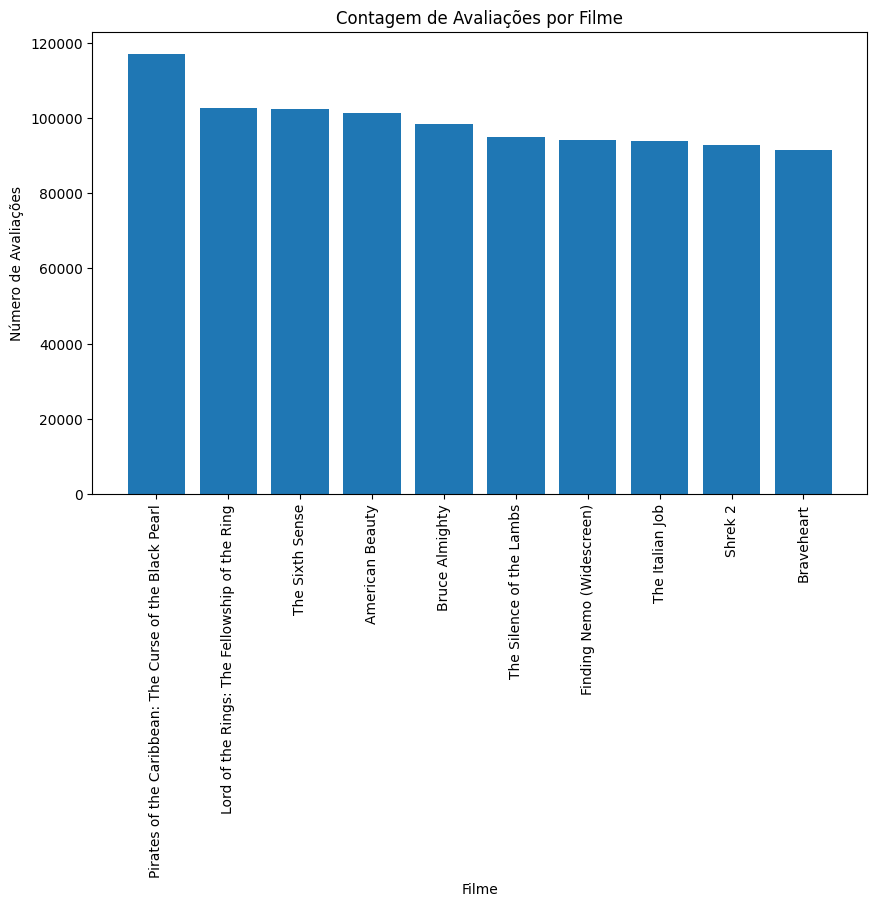

In [15]:
filmes_contagem = consulta_avaliacoes_contagem_10.select("name").rdd.flatMap(lambda x: x).collect()
num_avaliacoes = consulta_avaliacoes_contagem_10.select("num_avaliacoes").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.bar(filmes_contagem, num_avaliacoes)
plt.xlabel('Filme')
plt.ylabel('Número de Avaliações')
plt.title('Contagem de Avaliações por Filme')
plt.xticks(rotation=90)
plt.show()

Query04 - Qual a quantidade de avaliações que cada usuário fez?

In [34]:
consulta_avaliacoes_por_usuario = avaliacoes_por_filme.groupBy("User_ID") \
    .agg(count(col("Rating")).alias("num_avaliacoes_por_usuario")) \
    .orderBy(col("num_avaliacoes_por_usuario").desc())

Retorno da query04:

In [35]:
consulta_avaliacoes_por_usuario.show()

+-------+--------------------------+
|User_ID|num_avaliacoes_por_usuario|
+-------+--------------------------+
| 305344|                      1344|
| 387418|                      1339|
|2439493|                      1324|
|2118461|                      1305|
|1664010|                      1257|
| 716173|                      1169|
|1314869|                      1132|
|2056022|                      1072|
|1852040|                      1053|
|2606799|                      1039|
|2238060|                      1031|
| 322009|                      1029|
| 303948|                      1014|
|1114324|                       992|
| 491531|                       988|
|1461435|                       962|
|  16272|                       958|
|1639792|                       952|
| 727242|                       925|
| 752642|                       907|
+-------+--------------------------+


Criação do gráfico Query04:

In [75]:
#limite dos 10 usuários com a maior quantidade de avaliações
top_10_usuarios = consulta_avaliacoes_por_usuario.limit(10)

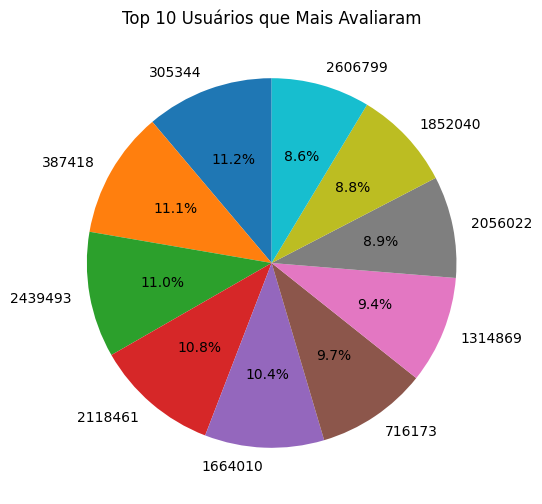

In [78]:
usuarios = top_10_usuarios.select("User_ID").rdd.flatMap(lambda x: x).collect()
num_avaliacoes_usuario = top_10_usuarios.select("num_avaliacoes_por_usuario").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.pie(num_avaliacoes_usuario, labels=usuarios, autopct='%1.1f%%', startangle=90)
plt.title('Top 10 Usuários que Mais Avaliaram')
plt.show()